# Preprocessing CVM data

In [1]:
%load_ext autoreload
%autoreload 2

Setting parent directory as current work directory.

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))

if module_path not in sys.path:
    sys.path.append(module_path)


### 1 - Imports

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

### 2 - Fetching macro-variables

In [6]:
from src.config import CVM_DATE_COLUMNS, DATA_PATH

### 3 - Loading data

In [7]:
from src.data.structure import get_full_df

In [8]:
df = get_full_df()

In [9]:
df.DT_FIM_EXERC.value_counts().sort_values(ascending=False).index[:12]

Index(['2020-12-31', '2021-12-31', '2010-12-31', '2011-12-31', '2019-12-31',
       '2018-12-31', '2013-12-31', '2012-12-31', '2017-12-31', '2016-12-31',
       '2015-12-31', '2014-12-31'],
      dtype='object')

### 4 - Preprocessing data

In [11]:
from src.preprocessing.preprocessing import (filter_main_rows, treat_date,
                                             treat_value)

df_raw = df.copy()
df = treat_value(df)
df = treat_date(df, date_columns=CVM_DATE_COLUMNS)
df = filter_main_rows(df)

In [19]:
df.head()

,CNPJ_CIA,DT_REFER,VERSAO,DENOM_CIA,CD_CVM,GRUPO_DFP,MOEDA,ORDEM_EXERC,DT_INI_EXERC,DT_FIM_EXERC,CD_CONTA,DS_CONTA,VL_CONTA,ST_CONTA_FIXA
0,00.000.000/0001-91,2011-12-31,4,BCO BRASIL S.A.,1023,DF Consolidado - Demonstração do Resultado,REAL,PENÚLTIMO,2010-01-01,2010-12-31,3.01,Receitas da Intermediação Financeira,8.514321e+10,S
1,00.000.000/0001-91,2011-12-31,4,BCO BRASIL S.A.,1023,DF Consolidado - Demonstração do Resultado,REAL,ÚLTIMO,2011-01-01,2011-12-31,3.01,Receitas da Intermediação Financeira,1.069198e+11,S
4,00.000.000/0001-91,2011-12-31,4,BCO BRASIL S.A.,1023,DF Consolidado - Demonstração do Resultado,REAL,PENÚLTIMO,2010-01-01,2010-12-31,3.02,Despesas da Intermediação Financeira,-5.077574e+10,S
5,00.000.000/0001-91,2011-12-31,4,BCO BRASIL S.A.,1023,DF Consolidado - Demonstração do Resultado,REAL,ÚLTIMO,2011-01-01,2011-12-31,3.02,Despesas da Intermediação Financeira,-6.997608e+10,S
10,00.000.000/0001-91,2011-12-31,4,BCO BRASIL S.A.,1023,DF Consolidado - Demonstração do Resultado,REAL,PENÚLTIMO,2010-01-01,2010-12-31,3.03,Resultado Bruto Intermediação Financeira,3.436746e+10,S


In [12]:
base_df = df.fillna(0).copy()
base_df.VL_CONTA = base_df.VL_CONTA / 1_000_000
structured_table = base_df.pivot_table(
    values='VL_CONTA',
    index=['DENOM_CIA','DT_REFER'],
    columns=['CD_CONTA']
).reset_index().fillna(1)

In [13]:
ds_contas = pd.DataFrame(df[['CD_CONTA','DS_CONTA']].value_counts()).sort_values(by='CD_CONTA')

In [14]:
ds_contas.to_csv('../utils/ds_contas.csv')

In [15]:
structured_table['liq_corrente'] = structured_table['1.01'] / structured_table['2.01']
structured_table['ROE'] = structured_table['3.07'] / structured_table['2.03']
structured_table['ROA'] = structured_table['3.07'] / (structured_table[[
    '1.01',
    '1.02',
    '1.03',
    '1.04',
    '1.05',
    '1.06',
    '1.07',
    '1.08']].sum(axis=1))
structured_table['gross_margin'] = structured_table['3.03'] / structured_table['3.01']
structured_table['op_margin'] = structured_table['3.05'] / structured_table['3.01']
structured_table['net_margin'] = structured_table['3.07'] / structured_table['3.01']

In [18]:
filter_condition = (structured_table.DT_REFER.isin(['2021-12-31','2020-12-31'])) &\
    (structured_table.net_margin > 0) &\
        (structured_table.net_margin < 10) &\
            (structured_table.ROE > 0) &\
                (structured_table.ROE < 1)
            
structured_table[filter_condition].sort_values(by='ROE',ascending=False).head(10)

CD_CONTA,DENOM_CIA,DT_REFER,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,...,3.11,3.12,3.13,3.99,liq_corrente,ROE,ROA,gross_margin,op_margin,net_margin
240,BCO BRASIL S.A.,2021-12-31,115342.0945,1.546529e+06,65482.81,31567.7615,18676.499,12338.628,6630.1685,1.0,...,16507.8770,1.0,1.0,0.0,44.780212,0.907439,0.009189,0.512458,0.158351,0.146993
1449,MINERVA S.A.,2021-12-31,12526.7065,5.969650e+03,1.00,1.0000,1.000,1.000,1.0000,1.0,...,647.9855,1.0,1.0,0.0,1.837564,0.904577,0.036526,0.182869,0.082576,0.029148
1082,HUMBERG AGRIBRASIL COMÉRCIO E EXPORTAÇÃO DE GR...,2021-12-31,584.0800,2.987100e+01,1.00,1.0000,1.000,1.000,1.0000,1.0,...,16.1490,1.0,1.0,0.0,1.147549,0.904521,0.039158,0.031153,0.020689,0.013668
670,CONSTRUTORA ADOLPHO LINDENBERG S.A.,2021-12-31,87.1165,7.094200e+01,1.00,1.0000,1.000,1.000,1.0000,1.0,...,4.7050,1.0,1.0,0.0,2.162505,0.902431,0.034277,0.302498,0.170620,0.109150
2106,UNIPAR CARBOCLORO S.A.,2021-12-31,2361.7230,3.016529e+03,1.00,1.0000,1.000,1.000,1.0000,1.0,...,1187.0240,1.0,1.0,0.0,1.565932,0.895580,0.337696,0.407316,0.363571,0.358006
873,EMBPAR PARTICIPAÇÕES S/A,2021-12-31,119.9945,8.665450e+01,1.00,1.0000,1.000,1.000,1.0000,1.0,...,44.8955,1.0,1.0,0.0,1.590827,0.811474,0.221431,0.172682,0.076918,0.067409
929,ETERNIT S.A. - EM RECUPERAÇÃO JUDICIAL,2021-12-31,613.1415,2.654580e+02,1.00,1.0000,1.000,1.000,1.0000,1.0,...,214.0895,1.0,1.0,0.0,2.851158,0.694628,0.305604,0.397661,0.295737,0.299286
589,CIA SIDERURGICA NACIONAL,2021-12-31,29179.2740,4.201135e+04,1.00,1.0000,1.000,1.000,1.0000,1.0,...,8944.1195,1.0,1.0,0.0,1.486186,0.679084,0.165134,0.423382,0.336698,0.301553
138,ATOM EMPREENDIMENTOS E PARTICIPAÇÕES S.A.,2021-12-31,26.3425,6.475000e-01,1.00,1.0000,1.000,1.000,1.0000,1.0,...,9.2000,1.0,1.0,0.0,8.300772,0.637370,0.293134,1.000000,0.262977,0.328080
1281,LIGHT ENERGIA S.A.,2021-12-31,1715.1910,2.002958e+03,1.00,1.0000,1.000,1.000,1.0000,1.0,...,262.3890,1.0,1.0,0.0,1.080401,0.637062,0.104044,0.740114,0.709094,0.390489


In [3]:
df

NameError: name 'df' is not defined

In [13]:
groupby_columns = ["DENOM_CIA"]
grouped_df = df.groupby(by=groupby_columns)

In [14]:
company_list = df.DENOM_CIA.unique().tolist()


CEMIG GERACAO E TRANSMISSAO S.A.


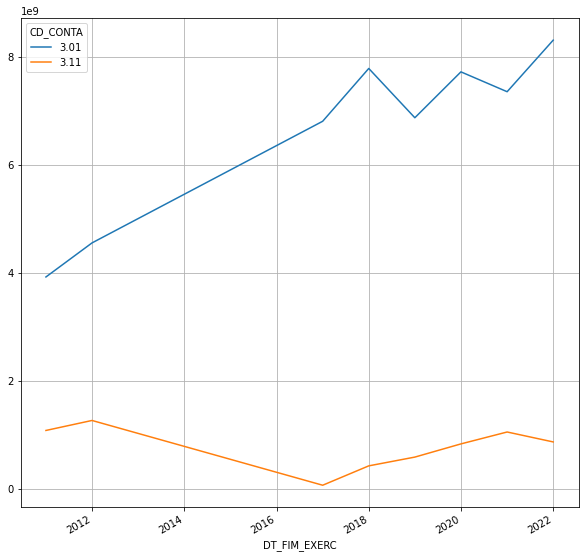

In [16]:
company_number = 100
print(company_list[company_number])
pd.pivot_table(
    grouped_df.get_group(company_list[company_number]),
    'VL_CONTA',
    ['CD_CONTA'],
    columns='DT_FIM_EXERC'
    ).dropna().T.plot(y=['3.01','3.11'],figsize=(10,10),grid=True)
plt.show()




## 5 - Exploring other dfps

In [17]:
[name for name in os.listdir("../" + DATA_PATH) if name[-4:] != ".zip"]

['dfp_cia_aberta_2011',
 'dfp_cia_aberta_2013',
 'dfp_cia_aberta_2021',
 'dfp_cia_aberta_2019',
 'dfp_cia_aberta_2017',
 'dfp_cia_aberta_2015']

In [25]:
df2 = read_cvm('../data/dfp_cia_aberta_2021/dfp_cia_aberta_BPP_con_2021.csv')

In [26]:
df2[(df2.CD_CVM == 1023)&(df2.ORDEM_EXERC == 'ÚLTIMO')].DS_CONTA.unique()

array(['Passivo Total',
       'Passivos Financeiros Avaliados ao Valor Justo através do Resultado',
       'Passivos Financeiros ao Custo Amortizado', 'Depósitos',
       'Captações no Mercado Aberto', 'Recursos Mercado Interfinanceiro',
       'Outras Captações',
       'Obrigações por emissão de títulos e valores mobiliários e outras obrigações',
       'Outros passivos financeiros', 'Provisões',
       'Provisões trabalhistas, fiscais e cíveis',
       'Provisões para perdas esperadas com garantias prestadas e compromissos de empréstimos',
       'Passivos Fiscais', 'Outros Passivos',
       'Passivos sobre Ativos Não Correntes a Venda e Descontinuados',
       'Passivos sobre Ativos Não Correntes a Venda',
       'Passivos sobre Ativos de Operações Descontinuadas',
       'Patrimônio Líquido Consolidado',
       'Patrimônio Líquido Atribuído ao Controlador',
       'Capital Social Realizado', 'Reservas de Capital',
       'Ágio na Emissão de Ações',
       'Reserva Especial de Ági